## Modulos y funciones

In [36]:
import pandas as pd 
import numpy as np 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
import seaborn as sns 
import pandas_profiling
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

In [2]:
#Funcion para mostrar todas las columnas del dataset
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

In [3]:
def fill_NA(dt, col, metodo):
    '''
    --------------------------------
    Funcion para rellenar los NAs.
    --------------------------------
    Parametros:
    - col: mariable del datset sobre el que se quiere aplicar
    - metodo: metodo de imputacion a utilizar. "median" o "mean" 
    
    Funcionamiento:
    
    Imputa por media o mediana la variable que se desee. 
    En primer lugar se aplica a las filas que se pueden agrupar por region y distrito.
    A continuaciÃ³n, aquellas que se pueden agrupar por region
    Finalmente imputa con los valores generales aquellas que no tengan datos de region.
    
    '''
        
    dt[col].fillna(dt.groupby(['region_code','district_code'])[col].transform(metodo), inplace = True)
    dt[col].fillna(dt.groupby(['region_code'])[col].transform(metodo), inplace = True)
    if metodo== 'mean':
        dt[col].fillna(dt[col].mean(), inplace = True)
    else:
        dt[col].fillna(dt[col].median(), inplace = True)

In [4]:
def cleaning_1(dt):
    #Elimino variables 

    #Recorded_by - Nombre del grupo que ha recogido los datos
    #wpt_name -Nombre del pozo

    dt.drop(['recorded_by', 'wpt_name'], axis = 1, inplace = True)

    #Variables categoricas con alta cardinalidad

    alta_cardinalidad = ['funder','installer', 'subvillage', 'lga', 'ward', 'scheme_name']
    dt.drop(alta_cardinalidad, axis=1, inplace= True)

    #Variables que representan lo mismo. Muchas de ellas son iguales que la misma variable sin el sufijo "_group" o solo se diferencian en una clase

    var_repetitivas = ['payment_type', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group','extraction_type_group', 'extraction_type', 'management', 'management_group']
    dt.drop(var_repetitivas, axis = 1, inplace=True)
    
    dt.drop('date_recorded', axis = 1,inplace=True)
    
    #Convierto los 0 de amount_tsh, gps-height, population, longitude y construction_year en NAs
    dt['amount_tsh'].replace(0.0, np.nan, inplace= True)
    dt['gps_height'].replace(0.0, np.nan, inplace= True)
    dt['population'].replace(0.0, np.nan, inplace= True)
    dt['longitude'].replace(0.0, np.nan, inplace= True)
    dt['construction_year'].replace(0.0, np.nan, inplace= True)
    fill_NA(dt, 'gps_height', 'mean')
    fill_NA(dt, 'longitude', 'mean')
    fill_NA(dt, 'population', 'median')
    fill_NA(dt, 'amount_tsh', 'median')
    fill_NA(dt, 'construction_year', 'median')
    
    var_bool = ['public_meeting', 'permit']

    for j in var_bool:
        dt[j].fillna(True, inplace=True)
        dt[j] = [1 if x == True else 0 for x in dt[j]]
        dt[j].astype('int64')
    
    dt['scheme_management'].fillna('VWC', inplace=True)
    
    dt['water_quality'].replace('unknown', 'soft', inplace=True)
    
    dt['quantity'].replace('unknown', 'enough', inplace=True)
    
    lista_categoricas = dt.select_dtypes(include='object').columns
    
    variables_dummies = lista_categoricas[1::]

    for k in variables_dummies:
        dummies = pd.get_dummies(dt[k],prefix=k)
        dt = pd.concat([dt, dummies], axis=1)
        dt.drop(k, axis=1, inplace=True)
        
    dt.set_index('id', inplace=True)
    
    return dt

In [5]:
def tune_random_forest(X, y, param_grid):
    
    # Definir los parametros a ajustar
    param_grid = param_grid
    
    #KFold utilizando stratified KFold
    
    kfold = StratifiedKFold(n_splits=5,
                            shuffle=True,
                            random_state=11)
    
    # Crear una instancia del clasificador
    rf = RandomForestClassifier()
    
    # Crear una instancia de GridSearchCV con el clasificador y los parametros a ajustar
    grid_search = GridSearchCV(rf, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    
    # Ajustar el GridSearchCV en los datos
    model = grid_search.fit(X, y)
    
    # Devolver los mejores parametros encontrados
    
    print('Best parameters', grid_search.best_params_)
    print('Best score', grid_search.best_score_)
    
    return model

In [6]:
def obtener_predicciones (modelo, datos, nombre_archivo):
    
    id = datos.index
    
    #Obtencion de la prediccion
    prediccion = modelo.predict(datos)
    
    #Conversion en df
    prediccion_df = pd.DataFrame({'id':id, 
                                'status_group':prediccion})
    
    #Cambio valores status_group
    prediccion_df.status_group.replace((0,1,2),
                            ('functional', 'functional needs repair', 'non functional'),
                            inplace=True
                            )
    
    #Guarda el csv
    prediccion_df.to_csv(f'../Tarea/Submissions/{nombre_archivo}.csv', index=False)

In [28]:
kfold_search = StratifiedKFold(n_splits=2,
                            shuffle=True,
                            random_state=11)

## Resumen

Se han realizado varias iteraciones, las principales (y las que se muestran en este trabajo) han consistido en:

- Limpieza de los datos y modificación de las variables.
- Análisis de distintos algoritmos de ML. 
- Realizacion de varias iteraciones con el mejor algoritmo de ML.

A continuación, se muestra una tabla resumen de los resultados obtenidos y una captura de las puntuaciones

In [7]:
modelos = [
    'Rf base',
    'Rf random search',
    'Rf grid search',
    'Rf + Oversampling'
    ]

resumen = pd.DataFrame({
                    'Iteracion' : [1,2,3,4],
                    'Modelo' : modelos,
                    'CV' : [0.800303, 0.808788, 0.808670, 0.808838],
                    'Score' : [0.8035, 0.8135, 0.8129, 0.8124]}
                    )

resumen.head()

,Iteracion,Modelo,CV,Score
0,1,Rf base,0.800303,0.8035
1,2,Rf random search,0.808788,0.8135
2,3,Rf grid search,0.808670,0.8129
3,4,Rf + Oversampling,0.808838,0.8124


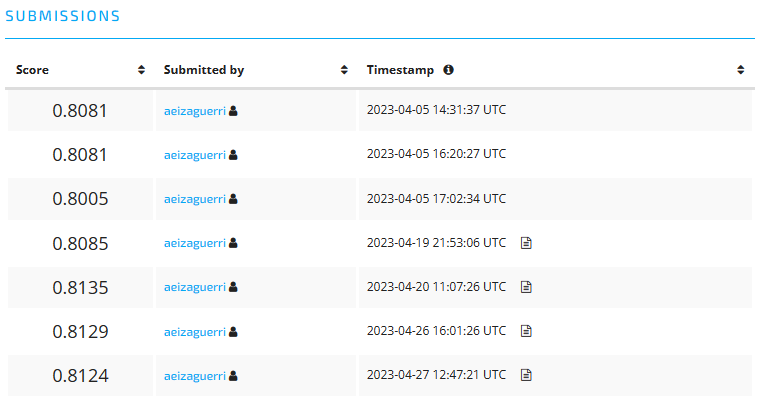

## Carga de datos

In [40]:
#Carga de los tres sets de datos
dt_train_labels = pd.read_csv('../Datasets/train_labels.csv')
dt_train_values = pd.read_csv('../Datasets/train_values.csv')
dt_predict_values = pd.read_csv('../Datasets/predict_values.csv')

In [41]:
#Union de los datasets de entrenamiento 
dt_train = pd.merge(dt_train_labels, dt_train_values, on='id', how='left')
dt_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [10]:
display_all(dt_train)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,functional,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


Aplico la misma limpieza a los datasets

In [42]:
dt_train_limpio = cleaning_1(dt_train)

dt_train_limpio.status_group.replace(('functional', 'functional needs repair', 'non functional'),
                            (0,1,2),
                            inplace=True
                            )

In [43]:
display_all(dt_train_limpio)

,status_group,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,permit,construction_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,scheme_management_Company,scheme_management_None,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,0,6000.0,1390.000000,34.938093,-9.856322,0,11,5,109.0,1,0,1999.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8776,0,200.0,1399.000000,34.698766,-2.147466,0,20,2,280.0,1,1,2010.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
34310,0,25.0,686.000000,37.460664,-3.821329,0,21,4,250.0,1,1,2009.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
67743,2,50.0,263.000000,38.486161,-11.155298,0,90,63,58.0,1,1,1986.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
19728,0,30.0,18.000000,31.130847,-1.825359,0,18,1,358.0,1,1,1995.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,0,10.0,1210.000000,37.169807,-3.253847,0,3,5,125.0,1,1,1999.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
27263,0,4700.0,1212.000000,35.249991,-9.070629,0,11,4,56.0,1,1,1996.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
37057,0,250.0,989.

In [12]:
dt_predict_values_limpio = cleaning_1(dt_predict_values)

In [13]:
dt_predict_values_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 83 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   amount_tsh                                   14850 non-null  float64
 1   gps_height                                   14850 non-null  float64
 2   longitude                                    14850 non-null  float64
 3   latitude                                     14850 non-null  float64
 4   num_private                                  14850 non-null  int64  
 5   basin                                        14850 non-null  object 
 6   region_code                                  14850 non-null  int64  
 7   district_code                                14850 non-null  int64  
 8   population                                   14850 non-null  float64
 9   public_meeting                               14850 non-null  int64  

In [50]:
X = dt_train_limpio.drop(['status_group', 'scheme_management_None'], axis=1) #Elimino scheme_management_None porque este no aparece en los datos de prediccion
y = dt_train_limpio['status_group']

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 91 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   amount_tsh                                   59400 non-null  float64
 1   gps_height                                   59400 non-null  float64
 2   longitude                                    59400 non-null  float64
 3   latitude                                     59400 non-null  float64
 4   num_private                                  59400 non-null  int64  
 5   region_code                                  59400 non-null  int64  
 6   district_code                                59400 non-null  int64  
 7   population                                   59400 non-null  float64
 8   public_meeting                               59400 non-null  int64  
 9   permit                                       59400 non-null  int64  

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify=y, random_state= 1234)

In [19]:
def compare_ml_algorithms(X, y, algorithms, names):
    
    # Crear un diccionario para almacenar las métricas para cada algoritmo
    metrics = {}
    
    # Ajustar cada algoritmo en el conjunto de entrenamiento y calcular las métricas en el conjunto de prueba
    for algorithm, name in zip(algorithms, names):
        algorithm.fit(X_train, y_train)
        y_pred = algorithm.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        metrics[name] = {'accuracy': accuracy}
    
    return metrics

In [20]:
#Comparacion de modelos 
algoritmos = [DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
nombres = ['Decision Tree', 'Random Forest', 'Gradient Boosting']

metrics = compare_ml_algorithms(X_train, y_train, algorithms=algoritmos, names=nombres)
print(metrics)

{'Decision Tree': {'accuracy': 0.7494949494949495}, 'Random Forest': {'accuracy': 0.8003367003367003}, 'Gradient Boosting': {'accuracy': 0.7522727272727273}}


El mejor modelo es el random forest

# Iteracion 1
Random forest sin ajustar hiperparametros
Score drivedata 0.8085

In [25]:
def model_perfom (model, X, y, n_splits):
    
    kfold = StratifiedKFold(n_splits=n_splits,
                        shuffle=True,
                        random_state=1234,
                        )

    cv = cross_val_score(model,
                    X,
                    y,
                    scoring="accuracy",
                    cv=kfold,
                    n_jobs=-1)

    print(cv)

In [26]:
#Modelo sin ajustar hiperparmetros utilizando el conjunto completo de datos de 
rf = RandomForestClassifier(n_jobs=-1)

model_perfom(rf, X, y, 5)

[0.80227273 0.80092593 0.80025253 0.79873737 0.8043771 ]


In [24]:
#Ajuste con el conjunto completo de test
classifier1 = rf.fit(X,y)

In [45]:
obtener_predicciones(classifier1, dt_predict_values_limpio, 'Iteracion_1')

## Iteracion 2 

Random forest ajustando hiperparametros de utilizando RandomizedSearch

Score 0.8135

In [46]:
#Tuneo de hiperparametros de forma aleatoria como primera aproximacion para muestrear muchas opciones de los parametros
#parametros a ajustar

random_param_grid = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'n_estimators': [int(x) for x in np.linspace(start=10, stop=2000, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

{'criterion': ['gini', 'entropy', 'log_loss'], 'n_estimators': [10, 231, 452, 673, 894, 1115, 1336, 1557, 1778, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [47]:
#Instancio el randomized search
rf_random = RandomizedSearchCV(estimator = rf,
                            param_distributions = random_param_grid,
                            n_iter = 100,
                            cv = kfold_search,
                            verbose=2,
                            random_state=42,
                            n_jobs = -1)

print(rf_random.best_params_)
print(rf_random.best_score_)

%time

In [29]:
#Modelo con los mejores parametros obtenidos en el RandomizedSearchCV
rf_random_tune = RandomForestClassifier(n_estimators= 894,
                                        min_samples_split= 2,
                                        min_samples_leaf= 2,
                                        max_features = 'log2',
                                        max_depth= 60,
                                        criterion= 'gini',
                                        bootstrap= False,
                                        n_jobs=-1)

model_perfom(rf_random_tune, X, y, 5)

[0.80740741 0.80664983 0.80782828 0.81052189 0.81296296]


In [30]:
# Ajuste del modelo con el conjunto completo
classifier2_random = rf_random_tune.fit(X, y)

In [51]:
obtener_predicciones(classifier2_random, dt_predict_values_limpio, 'Iteracion_2')

## Iteracion 3

Ajuste fino de hiperparametros partiendo de los obtenidos en el random de la iteracion anterior

Score driven data: 0.8129


In [52]:
#Ajuste fino de los hiperparametros utilizando como partida los obtenidos con el RandomizedSearch

param_grid = {
    'criterion': ['gini'],
    'bootstrap': [False],
    'max_depth': [45,50,55,60,65,70],
    'max_features': ['log2'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,350,700,800,850,900,1000]
}

# Instanciacion del gridsearch
grid_search = GridSearchCV(estimator = rf_random_tune,
                        param_grid = param_grid, 
                        cv = kfold_search,
                        n_jobs = -1,
                        verbose = 2)

print(grid_search.best_params_)
print(grid_search.best_score_)
%time

In [31]:
#Modelo con los mejores parametros obtenidos en el GridSearchCV
rf_grid_tune = RandomForestClassifier(n_estimators= 900,
                                    min_samples_split= 8,
                                    min_samples_leaf= 2,
                                    max_features = 'log2',
                                    max_depth= 50,
                                    criterion= 'gini',
                                    bootstrap= False,
                                    n_jobs=-1)

model_perfom(rf_grid_tune, X, y, 5)

[0.80622896 0.8047138  0.80808081 0.80824916 0.81178451]


In [34]:
# Ajuste del modelo
classifier3_grid = rf_grid_tune.fit(X, y)

In [55]:
obtener_predicciones(classifier3_grid, dt_predict_values_limpio, 'Iteracion_3')

## Revisión de los modelos

In [35]:
from sklearn.metrics import classification_report

pred = classifier2_random.predict(X_test)

print(classification_report(y_test,pred))

                         precision    recall  f1-score   support

             functional       0.89      0.98      0.93      6452
functional needs repair       0.93      0.54      0.68       863
         non functional       0.96      0.90      0.93      4565

               accuracy                           0.92     11880
              macro avg       0.93      0.80      0.85     11880
           weighted avg       0.92      0.92      0.91     11880



Leyenda:

    0 --> Functional

    1 --> Functional needs reapair

    2 --> Non Functional

Con la matriz de confusion del modelo de clasificacion 2, que es el que ha obtenido mejor resultado, se ve que falla bastante a la hora de clasificar las bombas funcionales que necesitan reparacion, probablemente debido al desbalanceo de los datos en comparacion con los otros dos grupos.

<AxesSubplot: >

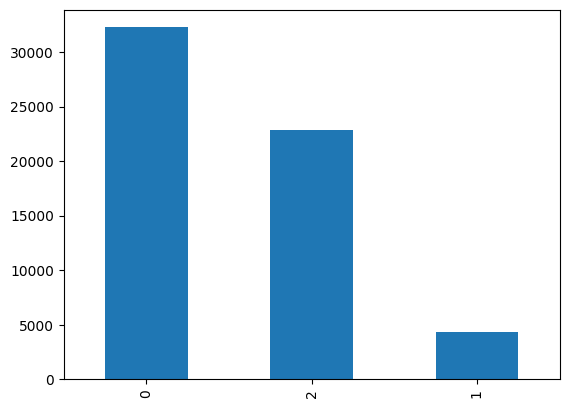

In [57]:
dt_train['status_group'].value_counts().plot(kind='bar')

In [58]:
#Importancia de kas variables en el modelo 2

imp = {}
for i in range(len(X_train.columns)):
    imp[X_train.columns[i]] = [classifier2_random.feature_importances_[i]]
pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"]).sort_values("Importance", ascending=False).head(10).style.background_gradient()

,Importance
quantity_dry,0.109400
longitude,0.101603
latitude,0.099566
construction_year,0.060299
gps_height,0.056479
waterpoint_type_other,0.046246
population,0.039554
quantity_enough,0.038274
extraction_type_class_other,0.036921
district_code,0.028073


## Iteracion 4

Balanceo de datos

Score 0.8124

In [51]:
#Oversampling de la calse minoritaria

print("Before OverSampling, counts of label '0': {}".format(sum(dt_train_limpio.status_group==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(dt_train_limpio.status_group==1)))
print("Before OverSampling, counts of label '2': {}".format(sum(dt_train_limpio.status_group==2)))

sm = SMOTE(sampling_strategy={1:8000}, random_state=2)
X_res, y_res = sm.fit_resample(X, y)

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==0)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==2)))

Before OverSampling, counts of label '0': 32259
Before OverSampling, counts of label '1': 4317
Before OverSampling, counts of label '2': 22824
After OverSampling, the shape of train_X: (63083, 91)
After OverSampling, the shape of train_y: (63083,)
After OverSampling, counts of label '1': 32259
After OverSampling, counts of label '0': 8000
After OverSampling, counts of label '0': 22824


In [52]:
model_perfom(rf_random_tune, X_res, y_res, 5)

[0.80851232 0.80700642 0.80835381 0.80968611 0.81547242]


In [53]:
classifier4_random_oversampled = rf_random_tune.fit(X_res,y_res)

In [63]:
obtener_predicciones(classifier4_random_oversampled, dt_predict_values_limpio, 'Iteracion_4')

In [54]:
#Vuelvo a comprobar la matriz de confusion para el nuevo modelo
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=1)

pred = classifier4_random_oversampled.predict(X_test)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      6452
           1       0.91      0.80      0.85      1600
           2       0.97      0.90      0.93      4565

    accuracy                           0.92     12617
   macro avg       0.93      0.89      0.91     12617
weighted avg       0.92      0.92      0.92     12617



Con el oversampling los valoeres referentes a la etiqueta de las bombas que necesitan reparacion, sin embargo, el score obtenido es inferior al modelo rf con tuneo aleatorio de hiperparametros. Quizás si se volviesen a ajustar los hiperparámetros, se podría mejorar la predicción.

## Resumen

In [65]:
# modelos = [
#     'Rf base',
#     'Rf random search',
#     'Rf grid search',
#     'Rf + Oversampling'
#     ]

# resumen = pd.DataFrame({
#                     'Iteracion' : [1,2,3,4],
#                     'Modelo' : modelos,
#                     'CV' : [cv1.mean(), cv2.mean(), cv3.mean(), cv4.mean()],
#                     'Score' : [0.8035, 0.8135, 0.8129, 0.8124]}
#                     )

In [66]:
#resumen.head()

,Iteracion,Modelo,CV,Score
0,1,Rf base,0.800303,0.8035
1,2,Rf random search,0.808788,0.8135
2,3,Rf grid search,0.808670,0.8129
3,4,Rf + Oversampling,0.808838,0.8124
